# VISCNN API DEMO

Before we begin, specify if you're using a machine with gpu's or not;

In [1]:
device = 'cuda:0'
#device = 'cpu'

## Model "Dissection"
 
VISCNN is a tool concerned with intermediary processing steps implemented by CNNs. One important intermediary that is often hidden in deep learning library's is the activation maps output by individual 2D kernels. Under normal circumstances, a convolutional layer has 'input' channels and 'output' channels. in pytorch, such a layer looks something like this;

In [7]:
import torch
from torch import nn


conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)
conv_layer

Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))


We can pass 3 input maps (here our input 'maps' will be 6x6 arrays) into 'conv_layer' and it will produce 5 output maps;


In [3]:
input_maps = torch.rand(1,3,6,6) # we use '1' as our first dimension, 
                                   # as normally pytorch assumes we are operating on some 'batch' of multiple images
output_maps = conv_layer(input_maps)
output_maps.shape

torch.Size([1, 5, 4, 4])

These input and output maps don't show us the whole story, there are intermediary activation maps produced inside 
these conv layers. These hidden maps are produced by apply a single convolution kernel, before getting added together pointwise to generate an output channel activation map. With VISCNN, we can 'dissect' convolutional layers to get access to the full computational process;

In [4]:
from viscnn.dissected_Conv2d import dissected_Conv2d


dissected_conv_layer = dissected_Conv2d(conv_layer)
dissected_conv_layer

/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


dissected_Conv2d(
  (preadd_conv): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), groups=3, bias=False)
)


Dissected Conv modules perform the same operations as the original conv;


In [5]:
output_maps_2 = dissected_conv_layer(input_maps)

torch.isclose(output_maps_2,output_maps) #output_maps is what was outputted by the original conv_layer

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]]]])

We can set up our dissected conv to store intermediary values within the module

In [6]:
dissected_conv_layer = dissected_Conv2d(conv_layer,store_activations=True)
output_maps_2 = dissected_conv_layer(input_maps)

print('pre pointwise added activation maps')
print(dissected_conv_layer.preadd_out.shape) #all output activation maps, before point-wise summing into output channels
print('\n')

print('pre pointwise added activation maps sorted by out channels')
print(dissected_conv_layer.format_edges().shape) ##fetch preadd activations as [img,out_channel, in_channel,h,w]
print('\n')

print('final output activation maps')
print(dissected_conv_layer.postbias_out.shape) #normal activation maps outputted by conv_2d after summing and adding bias
print('\n')


pre pointwise added activation maps
torch.Size([1, 15, 4, 4])


pre pointwise added activation maps sorted by out channels
(1, 5, 3, 4, 4)


final output activation maps
torch.Size([1, 5, 4, 4])




We can also 'dissect' any entire convolutional neural network, iterating through its modules and separating each instance of 'Conv2d' with 'dissected_Conv2d';

In [8]:
from torchvision.models import alexnet
from viscnn.dissected_Conv2d import dissect_model
from copy import deepcopy  #well dissect the model on a copy of the original model, 
                           #as or dissector function dissects the model in place

    
model = alexnet(pretrained=True)
_ = model.to(device).eval()

dissected_model = dissect_model(deepcopy(model), store_activations = False, store_ranks = False, device=device)

print('original model modules:')
print(model)

print('dissected model modules:')
print(dissected_model)

original model modules:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_fea

## feature visualization (with lucent)

For feature visualizations VISCNN uses the Lucent library, so we'll just demo their API here. For a more thorough demonstration of the power of lucent, check out the demos on their github (https://github.com/greentfrapp/lucent)

First we get a naming scheme, according to lucent, that we can use to reference the layers we want to visualize

In [8]:
from lucent.modelzoo.util import get_model_layers

get_model_layers(model)



['features',
 'features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

We can visualize quickly by just referencing a model, the layer name, and a numerical index of the feature

  2%|▏         | 11/512 [00:00<00:04, 101.39it/s]

layer 0, 10th feature


100%|██████████| 512/512 [00:05<00:00, 96.52it/s]



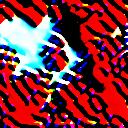

  2%|▏         | 10/512 [00:00<00:05, 98.12it/s]


 layer 8, 146th feature


100%|██████████| 512/512 [00:06<00:00, 82.98it/s]



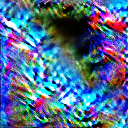

  1%|▏         | 7/512 [00:00<00:07, 68.43it/s]


 classification layer, 7th category (rooster)


100%|██████████| 512/512 [00:06<00:00, 74.48it/s]



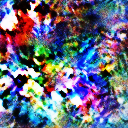

In [12]:
from lucent.optvis import render, param, transform, objectives


print('layer 0, 10th feature')
_ = render.render_vis(model, "features_0:10", show_inline=True)

print('\n layer 8, 146th feature')
_ = render.render_vis(model, "features_8:146", show_inline=True)

print('\n classification layer, 7th category (rooster)')
_ = render.render_vis(model, "classifier_6:7", show_inline=True)

We can visualizer our dissected model too, it produces the same feature visualizations (This will take longer, all operations on dissected_convs take more time and memory )

In [10]:
get_model_layers(dissected_model)

['features',
 'features_0',
 'features_0_preadd_conv',
 'features_1',
 'features_2',
 'features_3',
 'features_3_preadd_conv',
 'features_4',
 'features_5',
 'features_6',
 'features_6_preadd_conv',
 'features_7',
 'features_8',
 'features_8_preadd_conv',
 'features_9',
 'features_10',
 'features_10_preadd_conv',
 'features_11',
 'features_12',
 'avgpool',
 'classifier',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

  0%|          | 2/512 [00:00<00:26, 19.51it/s]


 layer 8, 146th feature


100%|██████████| 512/512 [00:22<00:00, 23.12it/s]



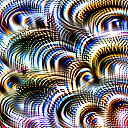

In [11]:
print('\n layer 8, 146th feature')
_ = render.render_vis(dissected_model, "features_8:146", show_inline=True)

Above we defaulted to a 'channel-wise' objective, which means 'generate an image that makes the sum over an entire feature-map high'. We could also use a 'neuron-wise' objective, which means 'generate an image which makes the central activation in the feature map high'. Neuron level visualizations often remove ambiguity in the channelwise visualization. For example, is feature_0:10 looking for black above white or white above black, or something else? 

(Note: one weird quirk with lucent visualizations: channel-wise visualizations often fail to optimize on dissected models, and neuron-wise visualizations often fail on undissected models. Not sure why.)

  2%|▏         | 10/512 [00:00<00:05, 94.11it/s]

layer 0, 10th feature 

channel-wise visualization


100%|██████████| 512/512 [00:04<00:00, 120.26it/s]



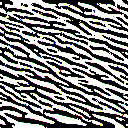

  1%|          | 4/512 [00:00<00:13, 38.77it/s]

neuron-wise visualization


100%|██████████| 512/512 [00:12<00:00, 41.97it/s]



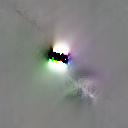

In [14]:
print('layer 0, 10th feature \n')

obj  = objectives.channel('features_0',10)
print('channel-wise visualization')
_ = render.render_vis(model, obj, show_inline=True)

print('neuron-wise visualization')
obj  = objectives.neuron('features_0',10)
_ = render.render_vis(dissected_model, obj, show_inline=True)

we can also get any linear combinations of features visualized using Lucent pretty easily. We can also fetch visualizations in parallel to make everything faster.

  1%|▏         | 7/512 [00:00<00:08, 63.05it/s]

feature_6:5                 feature_6:5                feature_6:5+6


100%|██████████| 512/512 [00:06<00:00, 80.22it/s]



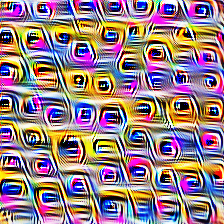
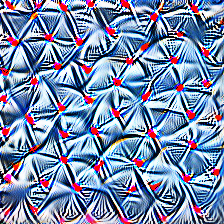
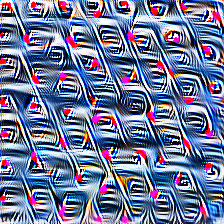

In [32]:
param_f = lambda: param.image(224, batch=3)   #set whats generated to 3 224x224 images

channel = lambda n: objectives.channel("features_6", n)

obj1 = objectives.channel("features_6",5, batch=0)  #batch 0 image set to visualize feature 5
obj2 = objectives.channel("features_6",6, batch=1)  #batch 1 image set to visualize feature 6
obj3 = objectives.channel("features_6",5, batch=2) + objectives.channel("features_6",6, batch=2)
#batch 2 image set to optimize a linear combination of both feature 5 and 6

obj = obj1+obj2+obj3


print('feature_6:5                 feature_6:5                feature_6:5+6')
_ = render.render_vis(model, obj, param_f, show_inline=True)

## Exploratory Visualizer

We can launch the visualizer tool from inside this notebook. It takes up a lot of memory, so'll we'll reset the notebook first, clearing all variables.

In [ ]:
%reset

from viscnn.visualizers.cnn_gui import launch_cnn_gui
launch_cnn_gui('alexnet_sparse')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


loading nodes rank data


/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/viscnn/ranks.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[rank_type+'_rank'] = np.where(df['layer'] == layer ,(df[rank_type+'_rank']-minimum)/(maximum-minimum),df[rank_type+'_rank'] )


loading node position data
loading convolutional kernels
loading edge data
loading activation maps
building graph from browser "state"
Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Oct/2021 00:21:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2021 00:21:17] "GET /assets/custom_divs.css?m=1632340318.7164469 HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2021 00:21:17] "GET /_dash-component-suites/dash_renderer/react@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2021 00:21:17] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_1m1617985068.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2021 00:21:17] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2021 00:21:17] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_1m1617985068.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2021 00:21:17] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_1_3m1617985573.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2021 00:21:17] "GET /_dash-component-suites/dash_core_com

"" in ablation list is not a node/edge
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/l

127.0.0.1 - - [06/Oct/2021 00:21:22] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: extract_subgraph_call

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/pytho

127.0.0.1 - - [06/Oct/2021 00:21:23] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [06/Oct/2021 00:21:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Oct/2021 00:21:52] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations
Updating cached rank dfs with overall
CALLED: switch_node_actmap_clickCALLED: switch_edge_actmaps_click



127.0.0.1 - - [06/Oct/2021 00:21:53] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.217977   
1              1   features_0      0            0           1  1.793965   
2              2   features_0      0            0           2  0.604349   
3              3   features_0      0            1           0  0.479389   
4              4   features_0      0            1           1  1.453592   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.089054   
250044    250044  features_10      4          255         252  0.062168   
250045    250045  features_10      4          255         253  0.000005   
250046    250046  features_10      4          255         254  0.053664   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000014   2.927448e-05  
1        

127.0.0.1 - - [06/Oct/2021 00:21:59] "POST /_dash-update-component HTTP/1.1" 200 -


## Circuit Visualizer

Circuit visualizers shows the connections between kernels and features in one image, in the manner of Olah 2020 https://distill.pub/2020/circuits/zoom-in/

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning:


Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/




/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse
generating feature_viz objective string for 5
deepviz image not found for 5, generating . . .
generating featviz with objective: conv_0:5


100%|██████████| 512/512 [00:04<00:00, 103.93it/s]



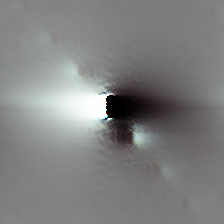

  2%|▏         | 10/512 [00:00<00:05, 90.63it/s]

generating feature_viz objective string for 6
deepviz image not found for 6, generating . . .
generating featviz with objective: conv_0:6


100%|██████████| 512/512 [00:04<00:00, 106.64it/s]



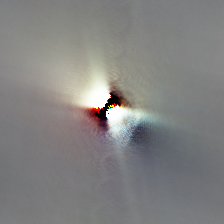

  3%|▎         | 13/512 [00:00<00:04, 122.69it/s]

generating feature_viz objective string for 10
deepviz image not found for 10, generating . . .
generating featviz with objective: conv_0:10


100%|██████████| 512/512 [00:04<00:00, 111.33it/s]



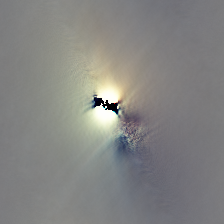

  2%|▏         | 12/512 [00:00<00:04, 115.17it/s]

generating feature_viz objective string for 11
deepviz image not found for 11, generating . . .
generating featviz with objective: conv_0:11


100%|██████████| 512/512 [00:04<00:00, 107.08it/s]



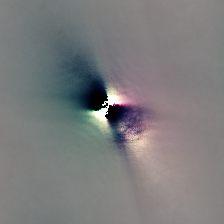

  2%|▏         | 10/512 [00:00<00:05, 94.16it/s]

generating feature_viz objective string for 14
deepviz image not found for 14, generating . . .
generating featviz with objective: conv_0:14


100%|██████████| 512/512 [00:04<00:00, 110.61it/s]



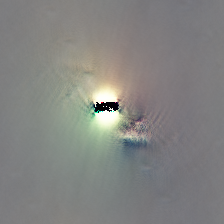

  3%|▎         | 13/512 [00:00<00:04, 124.19it/s]

generating feature_viz objective string for 16
deepviz image not found for 16, generating . . .
generating featviz with objective: conv_0:16


100%|██████████| 512/512 [00:04<00:00, 108.24it/s]



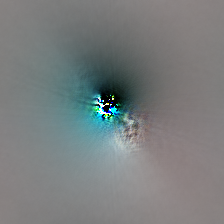

  2%|▏         | 9/512 [00:00<00:06, 82.79it/s]

generating feature_viz objective string for 43
deepviz image not found for 43, generating . . .
generating featviz with objective: conv_0:43


100%|██████████| 512/512 [00:04<00:00, 104.21it/s]



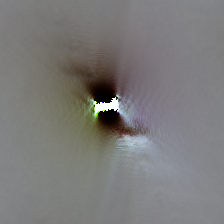

  2%|▏         | 10/512 [00:00<00:05, 93.24it/s]

generating feature_viz objective string for 47
deepviz image not found for 47, generating . . .
generating featviz with objective: conv_0:47


100%|██████████| 512/512 [00:04<00:00, 111.46it/s]



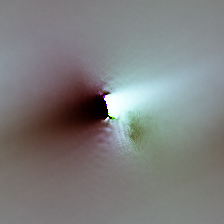

  3%|▎         | 13/512 [00:00<00:04, 122.95it/s]

generating feature_viz objective string for 50
deepviz image not found for 50, generating . . .
generating featviz with objective: conv_0:50


100%|██████████| 512/512 [00:04<00:00, 113.54it/s]



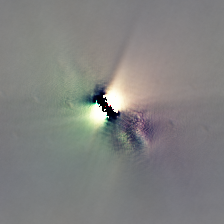

  3%|▎         | 13/512 [00:00<00:04, 123.41it/s]

generating feature_viz objective string for 56
deepviz image not found for 56, generating . . .
generating featviz with objective: conv_0:56


100%|██████████| 512/512 [00:04<00:00, 112.99it/s]



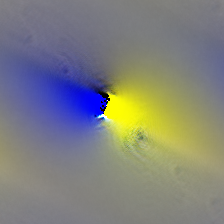

  2%|▏         | 12/512 [00:00<00:04, 117.43it/s]

generating feature_viz objective string for 212
deepviz image not found for 212, generating . . .
generating featviz with objective: conv_1:212


100%|██████████| 512/512 [00:04<00:00, 105.55it/s]



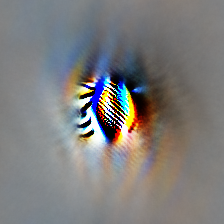

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [01/Oct/2021 13:21:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2021 13:21:52] "GET /assets/custom_divs.css?m=1632340318.7164469 HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2021 13:21:52] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_1m1617985068.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2021 13:21:52] "GET /_dash-component-suites/dash_renderer/react@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2021 13:21:52] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_1m1617985068.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2021 13:21:52] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2021 13:21:52] "GET /_dash-component-suites/dash_core_components/dash_core_components.v1_16_0m1617985098.min.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2021 13:21:52] "GET /_dash-component-suites/dash_core_co

None
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/da

127.0.0.1 - - [01/Oct/2021 13:21:54] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [01/Oct/2021 13:25:30] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 9, 'pointIndex': 9, 'x': 0, 'y': 4.5, 'text': '56', 'customdata': [56, 56, 0.4046248371735095]}]}
fig.clickData


127.0.0.1 - - [01/Oct/2021 13:25:40] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 8, 'pointIndex': 8, 'x': 0, 'y': 3.5, 'text': '50', 'customdata': [50, 50, 1]}]}
fig.clickData
resetting graph opacity


127.0.0.1 - - [01/Oct/2021 13:25:49] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 7, 'pointIndex': 7, 'x': 0, 'y': 2.5, 'text': '47', 'customdata': [47, 47, 0.5433902583289165]}]}
fig.clickData


127.0.0.1 - - [01/Oct/2021 13:25:59] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 8, 'pointIndex': 8, 'x': 0, 'y': 3.5, 'text': '50', 'customdata': [50, 50, 1]}]}
fig.clickData
resetting graph opacity


127.0.0.1 - - [01/Oct/2021 13:26:03] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 27, 'pointNumber': 2, 'pointIndex': 2, 'x': 2, 'y': 2.1}]}
fig.clickData


127.0.0.1 - - [01/Oct/2021 13:26:15] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 6, 'pointIndex': 6, 'x': 0, 'y': 1.5, 'text': '43', 'customdata': [43, 43, 0.6454426733724328]}]}
fig.clickData
resetting graph opacity


127.0.0.1 - - [01/Oct/2021 13:26:55] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 5, 'pointIndex': 5, 'x': 0, 'y': 0.5, 'text': '16', 'customdata': [16, 16, 0.296402196976007]}]}
fig.clickData


In [ ]:
%reset

from viscnn.visualizers.circuit_gui import launch_circuit_gui
subgraph_dict_path = 'prepped_models/alexnet_sparse/subgraphs/models/212_0.60.8.pt'

launch_circuit_gui(subgraph_dict_path,port=8050,params=None,viz_folder=None)

In [1]:
from viscnn import prepped_models_root_path

In [2]:
prepped_models_root_path

'/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models'